<a href="https://colab.research.google.com/github/xvh422/L4-Project/blob/main/Merger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install eagleSqlTools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import eagleSqlTools as sql
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

con = sql.connect("vwg533", password = "FZtn087h")

In [ ]:
sim_name = 'RefL0100N1504'
sim_size = 100.

Query_IDs = "SELECT \
            (MAG.u_nodust - MAG.r_nodust) as u_minus_r, \
            log10(AP.Mass_Star) as mass, \
            log10(SH.MassType_DM) as halo, \
            (AP.SFR/AP.Mass_Star) as ssfr, \
            SH.GalaxyID as id \
           FROM \
            %s_SubHalo as SH, \
            %s_Magnitudes as MAG, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = 28 and \
            SH.SubGroupNumber = 0 and \
            AP.Mass_Star > 1.0e9 and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = MAG.GalaxyID and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name, sim_name)

Data_IDs = sql.execute_query(con, Query_IDs)

In [ ]:
for i in range(len(Data_IDs['id'])):
  print('ID:' ,Data_IDs['id'][i])
  print('u-r:' ,Data_IDs['u_minus_r'][i])
  print('Stellar Mass:' ,Data_IDs['mass'][i])
  print('Halo Mass:' ,Data_IDs['halo'][i])
  print('sSFR:' ,Data_IDs['ssfr'][i])
  print('')

Streaming output truncated to the last 5000 lines.
sSFR: 6.4969606e-11

ID: 3768649
u-r: 1.3824377
Stellar Mass: 9.00073191609314
Halo Mass: 11.15935709961573
sSFR: 6.538736e-11

ID: 3769635
u-r: 1.6930485
Stellar Mass: 9.29333385363879
Halo Mass: 11.14021232588394
sSFR: 3.672762e-11

ID: 3816249
u-r: 1.260725
Stellar Mass: 9.262825991227901
Halo Mass: 11.044748081464155
sSFR: 1.0474754e-10

ID: 12306199
u-r: 1.5858727
Stellar Mass: 9.332510617099988
Halo Mass: 11.423141830292893
sSFR: 4.307147e-11

ID: 12307099
u-r: 1.4849472
Stellar Mass: 9.378643333348954
Halo Mass: 11.260522890940715
sSFR: 5.138408e-11

ID: 12360094
u-r: 1.4595127
Stellar Mass: 9.38417406995109
Halo Mass: 11.440937359380099
sSFR: 6.079514e-11

ID: 12370489
u-r: 1.3518887
Stellar Mass: 9.561334309188176
Halo Mass: 11.38355081262798
sSFR: 6.970397e-11

ID: 12391967
u-r: 1.398243
Stellar Mass: 9.298646647127779
Halo Mass: 11.398203256806086
sSFR: 7.4584824e-11

ID: 12406171
u-r: 1.410017
Stellar Mass: 9.45309051914926

In [3]:
sim_name = 'RefL0100N1504'
sim_size = 100.
galaxy_id_1 = 17360562 # Red
galaxy_id_2 = 16956975 # Blue

# Red
Query_1 = "SELECT \
            gal.Redshift as z, \
            gal.MassType_Star as mass, \
            gal.MassType_DM as halo, \
            gal.MassType_BH as bh, \
            gal.StarFormationRate as sfr \
          FROM \
            %s_Subhalo as gal, \
            %s_Subhalo as ref \
          WHERE \
            ref.GalaxyID=%s and \
            ((gal.SnapNum > ref.SnapNum and ref.GalaxyID \
            between gal.GalaxyID and gal.TopLeafID) or \
            (gal.SnapNum <= ref.SnapNum and gal.GalaxyID \
            between ref.GalaxyID and ref.TopLeafID)) \
          ORDER BY \
            gal.Redshift"%(sim_name, sim_name, galaxy_id_1)

# Blue
Query_2 = "SELECT \
            gal.Redshift as z, \
            gal.MassType_Star as mass, \
            gal.MassType_DM as halo, \
            gal.MassType_BH as bh, \
            gal.StarFormationRate as sfr \
          FROM \
            %s_Subhalo as gal, \
            %s_Subhalo as ref \
          WHERE \
            ref.GalaxyID=%s and \
            ((gal.SnapNum > ref.SnapNum and ref.GalaxyID \
            between gal.GalaxyID and gal.TopLeafID) or \
            (gal.SnapNum <= ref.SnapNum and gal.GalaxyID \
            between ref.GalaxyID and ref.TopLeafID)) \
          ORDER BY \
            gal.Redshift"%(sim_name, sim_name, galaxy_id_2)

Data_1 = sql.execute_query(con, Query_1)
Data_2 = sql.execute_query(con, Query_2)
r = len(Data_1['z'])
b = len(Data_2['z'])

In [4]:
def log_with_zeros(data): # Replaces zeroes with the smallest nonzero value.
  logs = np.empty(len(data))
  for i in range(0, len(data)):
    if data[i] == 0.0:
      logs[i] = 99.
    else:
      logs[i] = np.log10(data[i])
  m = logs.min()
  for j in range(0, len(logs)):
    if logs[j] == 99.:
      logs[j] = m
    else:
      logs[j] = logs[j]
  return logs

def divide_with_zeros(n, d):
  res = np.empty(len(n))
  for i in range(len(n)):
    if d[i] == 0:
      res[i] = 0
    else:
      res[i] = n[i]/d[i]
  return res

def remove_zeros(data):
  out = []
  for i in range(len(data)):
    if data[i] == 0:
      out = out
    else:
      out = out + [data[i]]
  return np.array(out)

In [5]:
Times = np.array([13.62, 13.53, 13.32, 13.25, 13.16, 13.04, 12.86, 12.75, 12.63, 12.46, 12.25, 12.01, 11.66, 11.16,
                  10.86, 10.53, 10.05, 9.49, 8.86, 7.93, 7.37, 6.71, 6.01, 5.19, 4.16, 3.23, 2.29, 1.24, 0.0]) # len = 29

In [6]:
sSFR_1 = divide_with_zeros(Data_1['sfr'], Data_1['mass']) * 10**9

r_snapnums = np.arange(29-len(Data_1['mass']), 29)[::-1]
LogMasses = log_with_zeros(Data_1['mass'])
r_medians = []
Range = 0.1

for i in range(len(LogMasses)):
  GalMass = LogMasses[i]
  Max = 10**(GalMass+Range)
  Min = 10**(GalMass-Range)
  MyQuery = "SELECT \
            log10(AP.Mass_Star) as mass, \
            (AP.SFR/AP.Mass_Star) as ssfr \
           FROM \
            %s_SubHalo as SH, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = %s and \
            SH.SubGroupNumber = 0 and \
            AP.Mass_Star < %s and \
            AP.Mass_Star > %s and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name, r_snapnums[i], Max, Min)
  Galaxies = sql.execute_query(con, MyQuery)
  r_medians = r_medians + [np.median(Galaxies['ssfr'])]
r_medians = np.array(r_medians) * 10**9 # Median sSFR within mass range from snapnum=28 to minimum snapnum of merger tree /Gyr^-1
print(r_medians)

[0.03145277 0.04426375 0.0519073  0.06733049 0.07693196 0.0840949
 0.11182603 0.14878794 0.19439969 0.24103575 0.32104946 0.43142556
 0.57466021 0.82500501 1.12629261 1.42548429 1.76407167 2.14956941
 2.37728903 1.9557016  2.00847183 1.7260382  1.59772218 0.71903217
 1.31725986 2.86695179 2.48016208]


In [7]:
sSFR_2 = divide_with_zeros(Data_2['sfr'], Data_2['mass']) * 10**9

b_snapnums = np.arange(29-len(Data_2['mass']), 29)[::-1]
LogMasses = log_with_zeros(Data_2['mass'])
b_medians = []
Range = 0.1

for i in range(len(LogMasses)):
  GalMass = LogMasses[i]
  Max = 10**(GalMass+Range)
  Min = 10**(GalMass-Range)
  MyQuery = "SELECT \
            log10(AP.Mass_Star) as mass, \
            (AP.SFR/AP.Mass_Star) as ssfr \
           FROM \
            %s_SubHalo as SH, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = %s and \
            SH.SubGroupNumber = 0 and \
            AP.Mass_Star < %s and \
            AP.Mass_Star > %s and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name, b_snapnums[i], Max, Min)
  Galaxies = sql.execute_query(con, MyQuery)
  b_medians = b_medians + [np.median(Galaxies['ssfr'])]
b_medians = np.array(b_medians) * 10**9 # Median sSFR within mass range from snapnum=28 to minimum snapnum of merger tree /Gyr^-1
print(b_medians)

[ 0.02405771  0.02572934  0.04732992  0.07231762  0.08528357  0.11577372
  0.14120793  0.17768065  0.21430449  0.25909075  0.33677899  0.5695221
  0.85839791  1.00210251  1.14185983  1.33379496  1.73380477  2.20429985
  2.42302467  2.42209164  2.69788814  2.62317568  2.93983859  2.90645708
  3.18581139  3.13368798  2.60194954 19.12739833]


In [8]:
r_diffs = log_with_zeros(sSFR_1) - log_with_zeros(r_medians)
print(r_diffs)

b_diffs = log_with_zeros(sSFR_2) - log_with_zeros(b_medians)
print(b_diffs)

[-2.18343444 -0.80086242 -1.5730599  -0.81991957 -1.23986218 -0.11698895
  0.05055423 -0.02498832 -0.07655144 -0.15466288  0.0121381   0.08210744
  0.12338818  0.06794418  0.0668638   0.08038851  0.16089438 -0.0497654
  0.25277732  0.03703123  0.34843891  0.43979357  0.16400304  0.71895286
 -3.80544698 -4.14319592 -4.08025559]
[ 0.32542091  0.33741609  0.34849894  0.28712833  0.20766614 -0.01316262
 -0.13540958 -0.18878199 -0.20750871 -0.18523656 -0.11804871  0.06939968
 -0.01818214  0.03998023  0.08663971  0.07665759  0.0307487   0.31981959
 -0.31830769 -0.03819816 -0.3652581   0.291878    0.13509114  0.22223687
 -0.62474203  0.33641562 -0.85012836 -2.57498072]


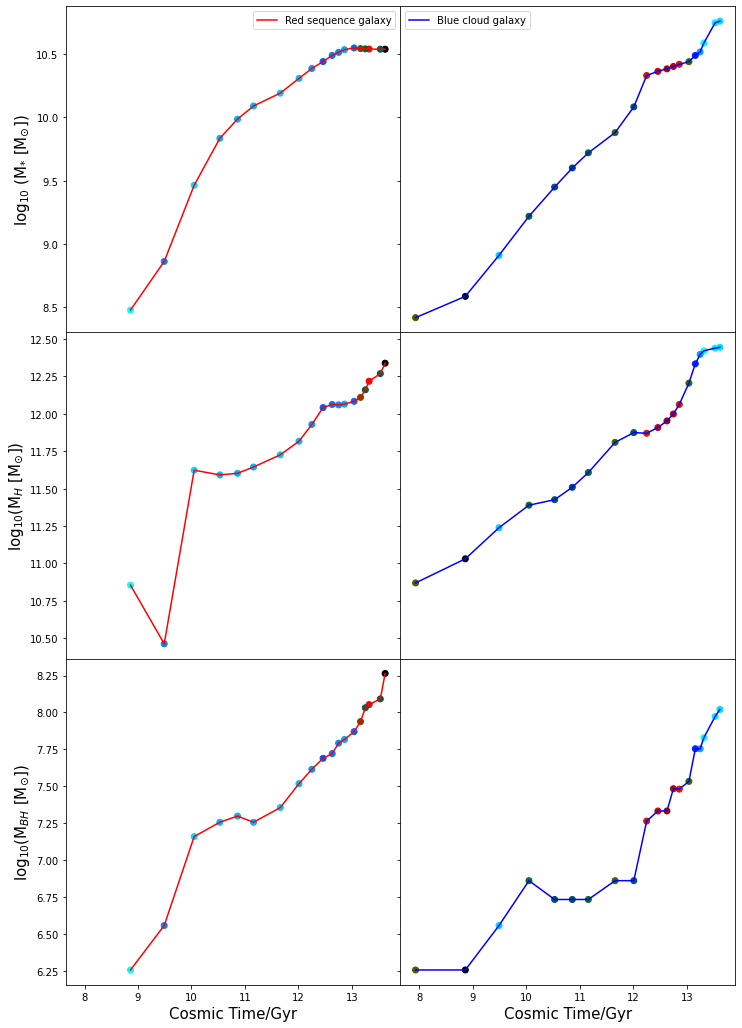

In [10]:
cvals = [-2, -1, 0, 1, 2]
colors = ["black","red","green","blue","cyan"]
norm = plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = col.LinearSegmentedColormap.from_list("", tuples)

final = 8
r_Times = Times[0:r-final]
b_Times = Times[0:b-final]

bh_red = remove_zeros(Data_1['bh'])
bh_blue = remove_zeros(Data_2['bh'])
r2 = len(bh_red) - len(Times[0:r-final])
b2 = len(bh_blue) - len(Times[0:b-final])

fig, (ax1, ax2, ax3) = plt.subplots(3, 2, figsize = (12,18), sharex = True, sharey = 'row')

# z=0
ax1[0].plot(r_Times, log_with_zeros(Data_1['mass'])[0:-final], color = 'r', label = 'Red sequence galaxy')
ax1[1].plot(b_Times, log_with_zeros(Data_2['mass'])[0:-final], color = 'b', label = 'Blue cloud galaxy')
ax2[0].plot(r_Times, log_with_zeros(Data_1['halo'])[0:-final], color = 'r')
ax2[1].plot(b_Times, log_with_zeros(Data_2['halo'])[0:-final], color = 'b')
ax3[0].plot(r_Times, log_with_zeros(bh_red)[0:-r2], color = 'r')
ax3[1].plot(b_Times, log_with_zeros(bh_blue)[0:-b2], color = 'b')

ax1[0].scatter(r_Times, log_with_zeros(Data_1['mass'])[0:-final], c = r_diffs[0:-final], cmap = cmap)
ax1[1].scatter(b_Times, log_with_zeros(Data_2['mass'])[0:-final], c = b_diffs[0:-final], cmap = cmap)
ax2[0].scatter(r_Times, log_with_zeros(Data_1['halo'])[0:-final], c = r_diffs[0:-final], cmap = cmap)
ax2[1].scatter(b_Times, log_with_zeros(Data_2['halo'])[0:-final], c = b_diffs[0:-final], cmap = cmap)
ax3[0].scatter(r_Times, log_with_zeros(bh_red)[0:-r2], c = r_diffs[0:-final], cmap = cmap)
ax3[1].scatter(b_Times, log_with_zeros(bh_blue)[0:-b2], c = b_diffs[0:-final], cmap = cmap)

ax3[0].set_xlabel(r'Cosmic Time/Gyr', fontsize=15)
ax3[1].set_xlabel(r'Cosmic Time/Gyr', fontsize=15)
ax1[0].set_ylabel(r'log$_{10}$ (M$_{*}$ [M$_{\odot}$])', fontsize=15)
ax2[0].set_ylabel(r'log$_{10}$(M$_{H}$ [M$_{\odot}$])', fontsize=15)
ax3[0].set_ylabel(r'log$_{10}$(M$_{BH}$ [M$_{\odot}$])', fontsize=15)
plt.subplots_adjust(hspace=.0, wspace=.0)
ax1[0].legend()
ax1[1].legend()
plt.savefig('Plot_2.jpeg')
plt.show()